#### Description
This code merges CPIS data from 2000 and 2021 with Africa shapefile country boundaries

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import yaml
import os
import utility

config = utility.load_config()

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

Understanding how Africa_boundaries is chunked to evaluate how to overlay it with the CPIS shapefiles

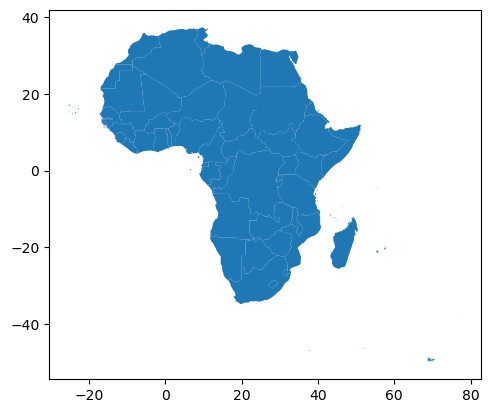

In [2]:
Africa_boundaries = gpd.read_file(resolve_path(config['Africa_boundaries_shp_path']))

cPIS2000 = gpd.read_file(resolve_path(config['CPIS_2000_shp_path']))
cPIS2021 = gpd.read_file(resolve_path(config['CPIS_2021_shp_path']))

Africa_boundaries.plot()
plt.show()

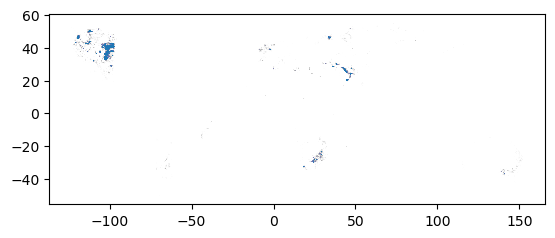

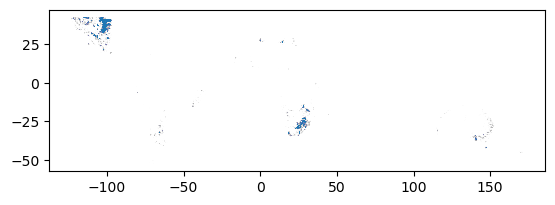

In [3]:
cPIS2000.plot()
plt.show()

cPIS2021.plot()
plt.show()

Overlay the 2000 and 2021 CPIS data with africa boundaries

In [4]:
CPIS2000_Africa = gpd.overlay(cPIS2000, Africa_boundaries, how = 'intersection')
CPIS2021_Africa = gpd.overlay(cPIS2021, Africa_boundaries, how = 'intersection')

# Add year column for clarity
CPIS2000_Africa['Year'] = 2000
CPIS2021_Africa['Year'] = 2021

# Reproject before computing area
CPIS2000_Africa = CPIS2000_Africa.to_crs(epsg=3857)
CPIS2021_Africa = CPIS2021_Africa.to_crs(epsg=3857)

# Add area column
CPIS2000_Africa['Area_m2'] = CPIS2000_Africa.geometry.area
CPIS2021_Africa['Area_m2'] = CPIS2021_Africa.geometry.area

# Save resulting files
CPIS2000_Africa.to_file(resolve_path(config['Africa_CPIS_2000_shp_path']))
CPIS2021_Africa.to_file(resolve_path(config['Africa_CPIS_2021_shp_path']))



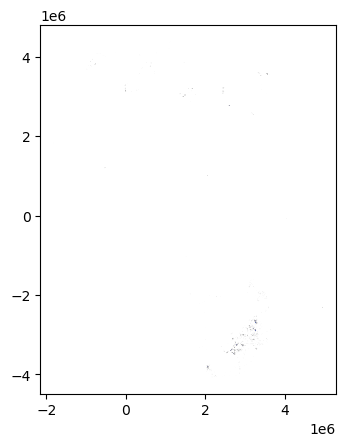

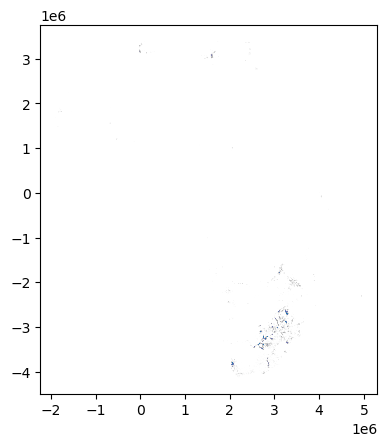

In [ ]:
CPIS2000_Africa.plot()
plt.show()

CPIS2021_Africa.plot()
plt.show()

Replication of Map from Africa_corporate_irrigation (GitHub via anna-boser)

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


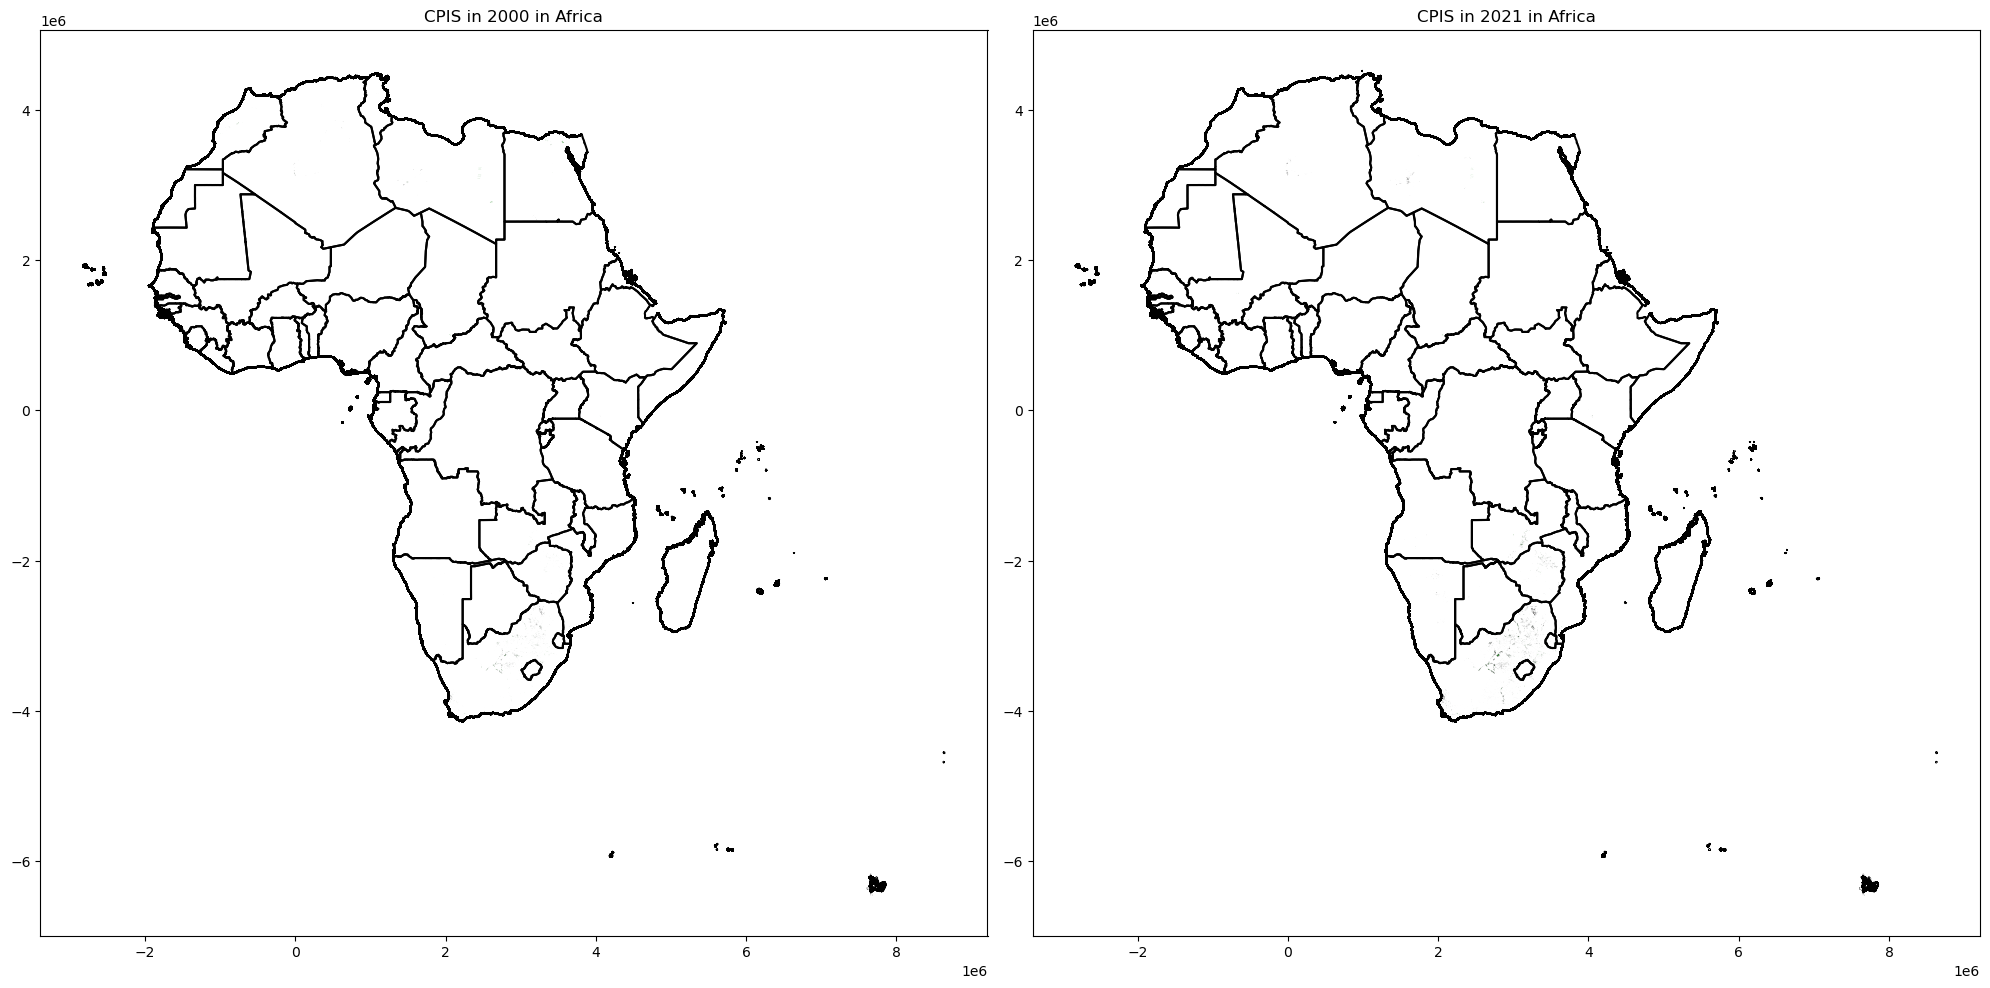

In [ ]:
CPIS_Africa = gpd.read_file(resolve_path(config['Africa_CPIS_shp_path']))
CPIS2000_Africa = gpd.read_file(resolve_path(config['Africa_CPIS_2000_shp_path']))
CPIS2021_Africa = gpd.read_file(resolve_path(config['Africa_CPIS_2021_shp_path']))

CPIS_Africa = CPIS_Africa.to_crs(epsg=3857)
Africa_boundaries_reproj = Africa_boundaries.to_crs(epsg=3857)
print(CPIS_Africa.crs)
print(CPIS2000_Africa.crs)
print(CPIS2021_Africa.crs)
print(Africa_boundaries_reproj.crs)

# Buffer the geometry to make it more visible
CPIS_Africa['geometry'] = CPIS_Africa.geometry.buffer(0.5)

# Create a single plot with two facets
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the CPIS data for 2000
Africa_boundaries_reproj.boundary.plot(ax=axes[0], color='black')
CPIS_Africa[CPIS_Africa['Year'] == 2000].plot(ax=axes[0], color='green')
axes[0].set_title('CPIS in 2000 in Africa')

# Plot the CPIS data for 2021
Africa_boundaries_reproj.boundary.plot(ax=axes[1], color='black')
CPIS_Africa[CPIS_Africa['Year'] == 2021].plot(ax=axes[1], color='green')
axes[1].set_title('CPIS in 2021 in Africa')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(resolve_path(config['1_Figure0']))
plt.show()
